In [1]:
import geopandas as gpd

link="midisceplanmap_repro.geojson"
midis=gpd.read_file(link)
midis.columns

Index(['DEPARTAMENTO', 'PROVINCIA', 'DISTRITO', 'INSTITUCIO', 'Pres1_Todo',
       'Pres1_PeruLibre', 'Pres1_PLprop', 'Pres2_Todo', 'Pres2_PeruLibre',
       'Pres2_PLprop', 'Congre_PeruLibre', 'Congre_Todo',
       'Congre_PeruLibre_prop', 'programado_yana', 'ejecutado_yana',
       'yanaProp', 'programado_b600', 'ejecutado_b600', 'b600prop', 'nivel',
       'ubigeo', 'pobTotal', 'pobDiscapacidad', 'superficie', 'densidad',
       'altitud', 'latitud', 'longitud', 'numeroCentrosPoblados',
       'porcentajeDesnutCronica5menos', 'conteoPobres', 'conteoPobresExtremos',
       'porcentajePobrezaExtrema', 'propDisca', 'preCovid', 'postCovid',
       'covidShare', 'LisaYanaQs', 'LisaYanaSig', 'LisaYanaSpots',
       'LisaB600Qs', 'LisaB600Sig', 'LisaB600Spots', 'LisaBV_YanaB600Qs',
       'LisaBV_YanaB600Sig', 'LisaBV_YanaB600Spots', 'LisaCovidQs',
       'LisaCovidSig', 'LisaCovidSpots', 'LisaBV_YanaCovidQs',
       'LisaBV_YanaCovidSig', 'LisaBV_SpotsYanaCovid', 'LisaBV_B600CovidQs',
   

In [2]:
from pysal.lib import weights

w = weights.distance.KNN.from_dataframe(midis, k=8)
# Row-standardization
w.transform = "R"

In [3]:
from esda.moran import Moran

moranYana=Moran(midis['yanaProp'], w)
moranYana.I,moranYana.p_sim

(0.4820906153109157, 0.001)

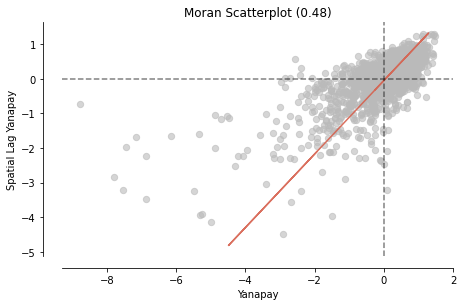

In [4]:
import matplotlib.pyplot as plt

from splot.esda import moran_scatterplot
fig, ax = moran_scatterplot(moranYana, aspect_equal=True)
ax.set_xlabel('Yanapay')
ax.set_ylabel('Spatial Lag Yanapay')
plt.show()

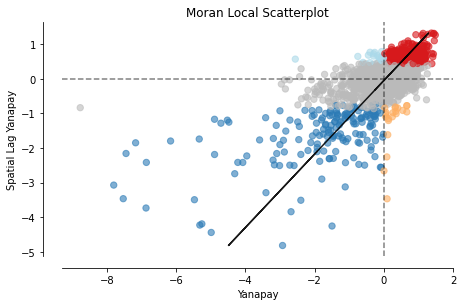

In [5]:
from esda.moran import Moran_Local

# calculate Moran_Local and plot

lisaYanapay = Moran_Local(y=midis['yanaProp'], w=w,seed=2022)
fig, ax = moran_scatterplot(lisaYanapay,p=0.05)
ax.set_xlabel('Yanapay')
ax.set_ylabel('Spatial Lag Yanapay')
plt.show()

In [6]:
lisaYanapay.q

array([3, 4, 3, ..., 1, 1, 3])

In [7]:
# guardando cuadrante:
q_labels = ['1 HH', '2 LH', '3 LL', '4 HL']
labels = [q_labels[i-1] for i in lisaYanapay.q]
midis=midis.assign(LisaYanaQs=labels)

In [8]:
# guardando LISAs significativos
lisaYanapay_sig = 1 * (lisaYanapay.p_sim < 0.05) # de True/False a 1/0
labels = ['no-sig', 'significativo']  
labels = [labels[i] for i in lisaYanapay_sig]
midis=midis.assign(LisaYanaSig=labels)

In [9]:
hotSpot = 1 * (lisaYanapay_sig * lisaYanapay.q==1)
coldOutlier = 2 * (lisaYanapay_sig * lisaYanapay.q==2)
coldSpot = 3 * (lisaYanapay_sig * lisaYanapay.q==3)
hotOutlier = 4 * (lisaYanapay_sig * lisaYanapay.q==4)


spots = hotSpot + coldOutlier + coldSpot + hotOutlier
spot_labels = [ '0 no_sig', '1 hotSpot', '2 coldOutlier', '3 coldSpot', '4 hotOutlier']
labels = [spot_labels[i] for i in spots]
midis=midis.assign(LisaYanaSpots=labels)

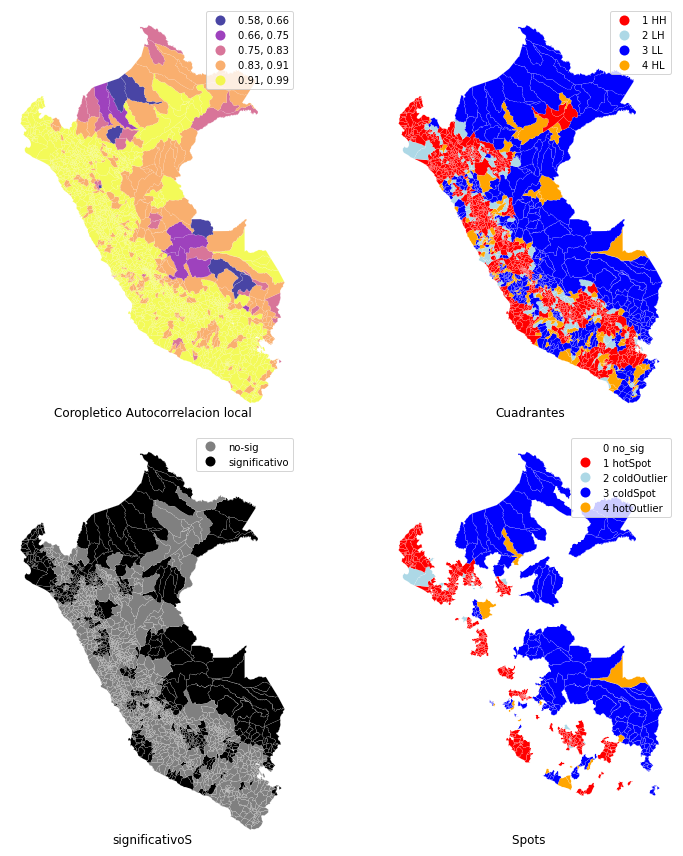

In [10]:
# 4 graficas
from matplotlib import colors
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
axs = axs.flatten()

# COROPLETICO DEL LISA #
ax = axs[0]
midis.plot(column='yanaProp', 
                 cmap='plasma', 
                 scheme='equal_interval',
                 k=5,
                 edgecolor='white',
                 linewidth=0.1, 
                 alpha=0.75,
                 legend=True, 
                 ax=ax)

# CUADRANTES #
ax = axs[1]
hmap = colors.ListedColormap([ 'red', 'lightblue', 'blue', 'orange'])
midis.plot(column='LisaYanaQs', 
                 categorical=True,
                 cmap=hmap,
                 linewidth=0.1, 
                 ax=ax,
                 edgecolor='white',
                 legend=True)

# LISA SIGNIFICATIVO #

ax = axs[2]
hmap = colors.ListedColormap(['grey','black'])
midis.plot(column='LisaYanaSig',
                 categorical=True,
                 cmap=hmap, linewidth=0.1, ax=ax,
                 edgecolor='white', legend=True)

                       
# LISA SPOTS #
ax = axs[3]

hmap = colors.ListedColormap([ 'white', 'red', 'lightblue', 'blue', 'orange'])
midis.plot(column='LisaYanaSpots',
                 categorical=True,
                 cmap=hmap,
                 linewidth=0.1, ax=ax,
                 edgecolor='white', legend=True)

for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(['Coropletico Autocorrelacion local', 
                  'Cuadrantes', 
                  'significativoS', 
                  'Spots '][i], y=0)

f.tight_layout()

plt.show()

In [11]:
lisaB600 = Moran_Local(y=midis['b600prop'], w=w,seed=2022)

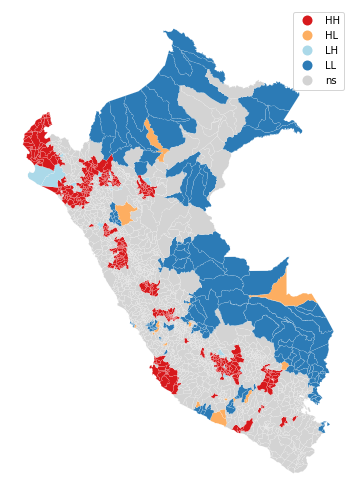

In [20]:
from splot.esda import lisa_cluster

lisa_cluster(lisaYanapay, midis, p=0.05, figsize = (9,9))
plt.show()

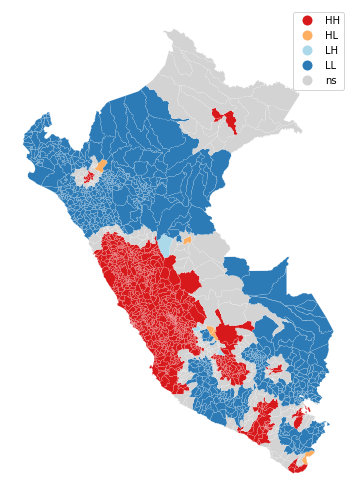

In [93]:
from splot.esda import lisa_cluster

lisa_cluster(lisaB600, midis, p=0.05, figsize = (9,9))
plt.show()

In [95]:
from esda.moran import Moran_Local_BV

lisaYanaB600 = Moran_Local_BV(midis['yanaProp'], 
                                  midis['b600prop'], 
                                  w)

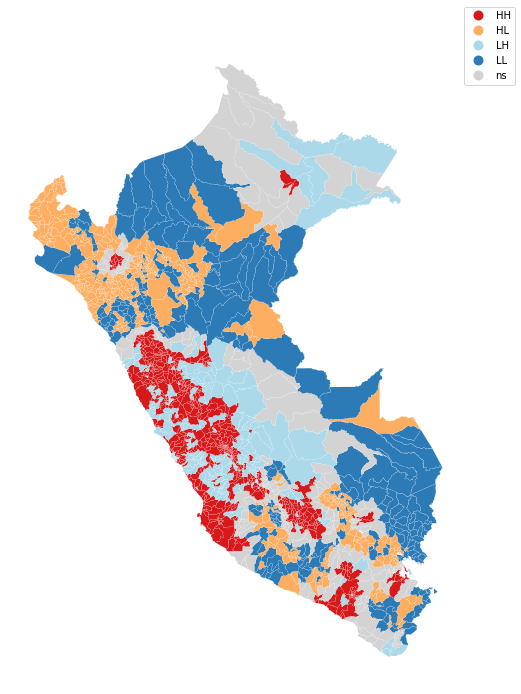

In [96]:
from splot.esda import lisa_cluster

f, ax = plt.subplots(1, figsize=(12, 12))
fig = lisa_cluster(lisaYanaB600, 
                   midis,ax=ax,
                   legend_kwds={'loc': 'upper left', 
                                'bbox_to_anchor': (0.99, 1.05)})
plt.show()

In [97]:
# guardando cuadrante:
q_labels = ['1 HH', '2 LH', '3 LL', '4 HL']
labels = [q_labels[i-1] for i in lisaB600.q]
midis=midis.assign(LisaB600Qs=labels)

In [98]:
# guardando LISAs significativos
lisaB600_sig = 1 * (lisaB600.p_sim < 0.05) # de True/False a 1/0
labels = ['no-sig', 'significativo']  
labels = [labels[i] for i in lisaB600_sig]
midis=midis.assign(LisaB600Sig=labels)

In [99]:
hotSpot = 1 * (lisaB600_sig * lisaB600.q==1)
coldOutlier = 2 * (lisaB600_sig * lisaB600.q==2)
coldSpot = 3 * (lisaB600_sig * lisaB600.q==3)
hotOutlier = 4 * (lisaB600_sig * lisaB600.q==4)


spots = hotSpot + coldOutlier + coldSpot + hotOutlier
spot_labels = [ '0 no_sig', '1 hotSpot', '2 coldOutlier', '3 coldSpot', '4 hotOutlier']
labels = [spot_labels[i] for i in spots]
midis=midis.assign(LisaB600Spots=labels)

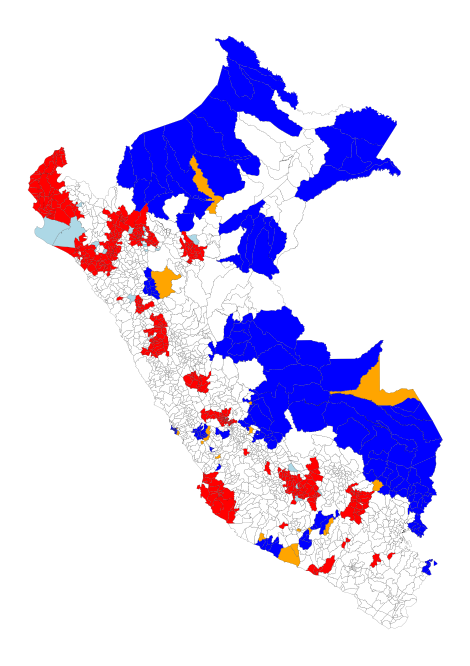

In [60]:
hmap = colors.ListedColormap([ 'white', 'red', 'lightblue', 'blue', 'orange'])

f, ax = plt.subplots(1, figsize=(12, 12))

midis.plot(column='LisaYanaSpots',
                 categorical=True,
                 cmap=hmap,ax=ax,
                 linewidth=0.1,
                 edgecolor='black')#, legend=True)
ax.set_axis_off()
plt.show()

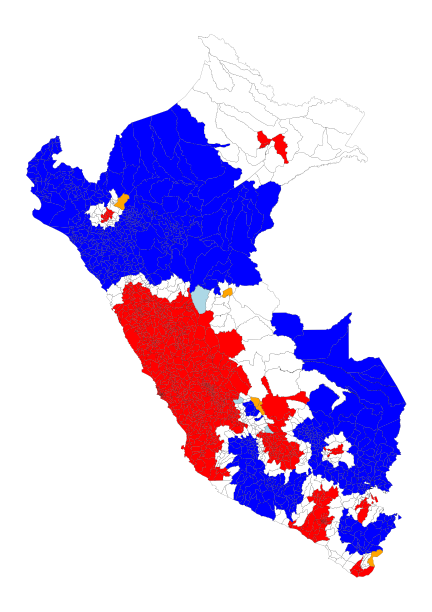

In [53]:
f, ax = plt.subplots(1, figsize=(11, 11))
midis.plot(column='LisaB600Spots',
                 categorical=True,
                 cmap=hmap,ax=ax,
                 linewidth=0.1,
                 edgecolor='black', legend=False)

ax.set_axis_off()
plt.show()

In [100]:
#HH=1, LH=2, LL=3, HL=4
# guardando cuadrante:
q_labels = ['1 HH', '2 LH', '3 LL', '4 HL']
labels = [q_labels[i-1] for i in lisaYanaB600.q]
midis=midis.assign(LisaBV_YanaB600Qs=labels)

In [101]:
# guardando LISAs significativos
lisaYanaB600_sig = 1 * (lisaYanaB600.p_sim < 0.05) # de True/False a 1/0
labels = ['no-sig', 'significativo']  
labels = [labels[i] for i in lisaYanaB600_sig]
midis=midis.assign(LisaBV_YanaB600Sig=labels)

In [102]:
hotSpot = 1 * (lisaYanaB600_sig * lisaYanaB600.q==1)
coldOutlier = 2 * (lisaYanaB600_sig * lisaYanaB600.q==2)
coldSpot = 3 * (lisaYanaB600_sig * lisaYanaB600.q==3)
hotOutlier = 4 * (lisaYanaB600_sig * lisaYanaB600.q==4)


spots = hotSpot + coldOutlier + coldSpot + hotOutlier
spot_labels = [ '0 no_sig', '1 hotSpot', '2 coldOutlier', '3 coldSpot', '4 hotOutlier']
labels = [spot_labels[i] for i in spots]
midis=midis.assign(LisaBV_YanaB600Spots=labels)

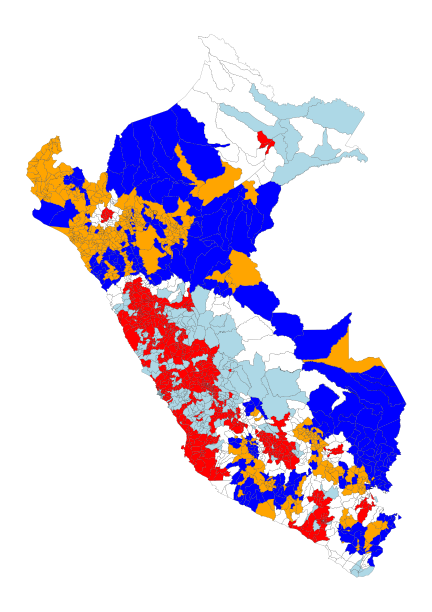

In [54]:
f, ax = plt.subplots(1, figsize=(11, 11))
midis.plot(column='LisaBV_YanaB600Spots',
                 categorical=True,
                 cmap=hmap,ax=ax,
                 linewidth=0.1,
                 edgecolor='black')
ax.set_axis_off()
plt.show()

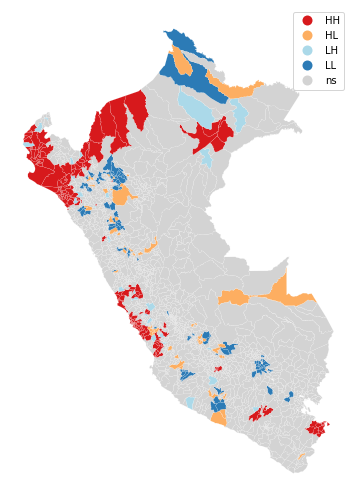

In [103]:


covid = Moran_Local(y=midis['covidShare'], w=w,seed=2022)

lisa_cluster(covid, midis, p=0.05, figsize = (9,9))
plt.show()

In [104]:
# guardando cuadrante:
q_labels = ['1 HH', '2 LH', '3 LL', '4 HL']
labels = [q_labels[i-1] for i in covid.q]
midis=midis.assign(LisaCovidQs=labels)

# guardando LISAs significativos
covid_sig = 1 * (covid.p_sim < 0.05) # de True/False a 1/0
labels = ['no-sig', 'significativo']  
labels = [labels[i] for i in covid_sig]
midis=midis.assign(LisaCovidSig=labels)

hotSpot = 1 * (covid_sig * covid.q==1)
coldOutlier = 2 * (covid_sig * covid.q==2)
coldSpot = 3 * (covid_sig * covid.q==3)
hotOutlier = 4 * (covid_sig * covid.q==4)
spots = hotSpot + coldOutlier + coldSpot + hotOutlier
spot_labels = [ '0 no_sig', '1 hotSpot', '2 coldOutlier', '3 coldSpot', '4 hotOutlier']
labels = [spot_labels[i] for i in spots]
midis=midis.assign(LisaCovidSpots=labels)


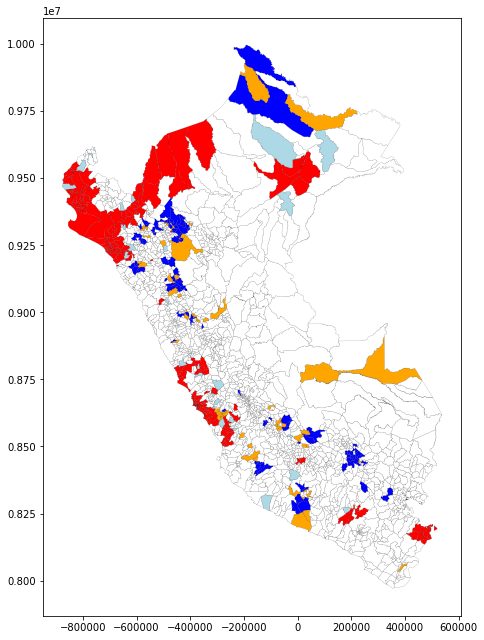

In [59]:
f, ax = plt.subplots(1, figsize=(11, 11))
midis.plot(column='LisaCovidSpots',
                 categorical=True,
                 cmap=hmap,ax=ax,
                 linewidth=0.1,
                 edgecolor='black')#, legend=True)

plt.show()

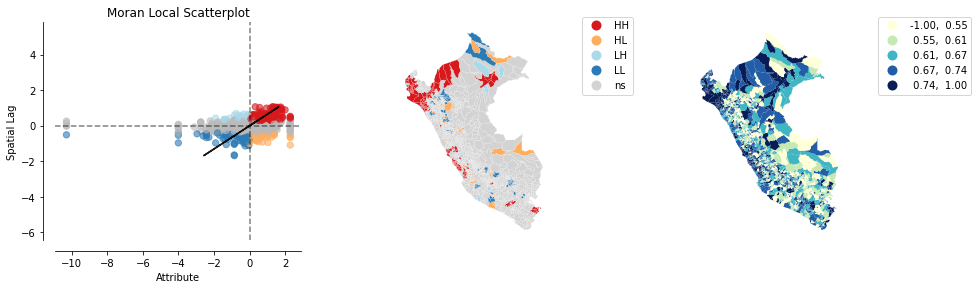

In [53]:
from splot.esda import plot_local_autocorrelation
plot_local_autocorrelation(covid,midis, 'covidShare')
plt.show()

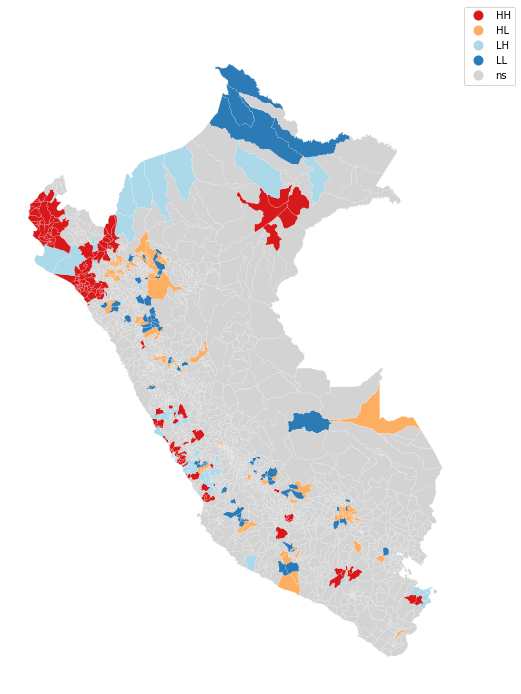

In [105]:
from esda.moran import Moran_Local_BV

lisaYanaCovid = Moran_Local_BV(midis['yanaProp'], 
                                  midis['covidShare'], 
                                  w)
from splot.esda import lisa_cluster

f, ax = plt.subplots(1, figsize=(12, 12))
fig = lisa_cluster(lisaYanaCovid, 
                   midis,ax=ax,
                   legend_kwds={'loc': 'upper left', 
                                'bbox_to_anchor': (0.99, 1.05)})
plt.show()

In [106]:
# guardando cuadrante:
q_labels = ['1 HH', '2 LH', '3 LL', '4 HL']
labels = [q_labels[i-1] for i in lisaYanaCovid.q]
midis=midis.assign(LisaBV_YanaCovidQs=labels)

# guardando LISAs significativos
lisaYanaCovid_sig = 1 * (lisaYanaCovid.p_sim < 0.05) # de True/False a 1/0
labels = ['no-sig', 'significativo']  
labels = [labels[i] for i in lisaYanaCovid_sig]
midis=midis.assign(LisaBV_YanaCovidSig=labels)

hotSpot = 1 * (lisaYanaCovid_sig * lisaYanaCovid.q==1)
coldOutlier = 2 * (lisaYanaCovid_sig * lisaYanaCovid.q==2)
coldSpot = 3 * (lisaYanaCovid_sig * lisaYanaCovid.q==3)
hotOutlier = 4 * (lisaYanaCovid_sig * lisaYanaCovid.q==4)
spots = hotSpot + coldOutlier + coldSpot + hotOutlier
spot_labels = [ '0 no_sig', '1 hotSpot', '2 coldOutlier', '3 coldSpot', '4 hotOutlier']
labels = [spot_labels[i] for i in spots]
midis=midis.assign(LisaBV_SpotsYanaCovid=labels)

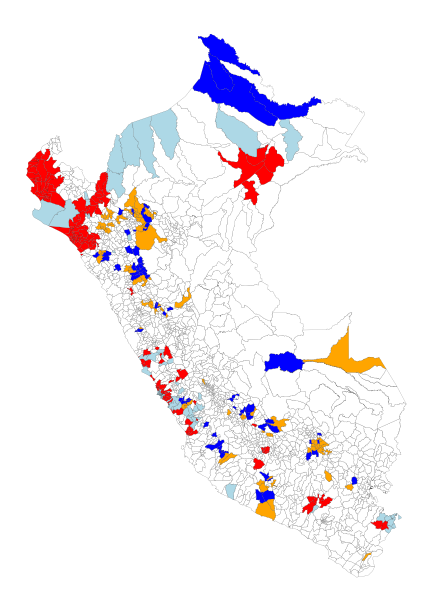

In [55]:
f, ax = plt.subplots(1, figsize=(11, 11))
midis.plot(column='LisaBV_SpotsYanaCovid',
                 categorical=True,
                 cmap=hmap,ax=ax,
                 linewidth=0.1,
                 edgecolor='black')
ax.set_axis_off()

plt.show()

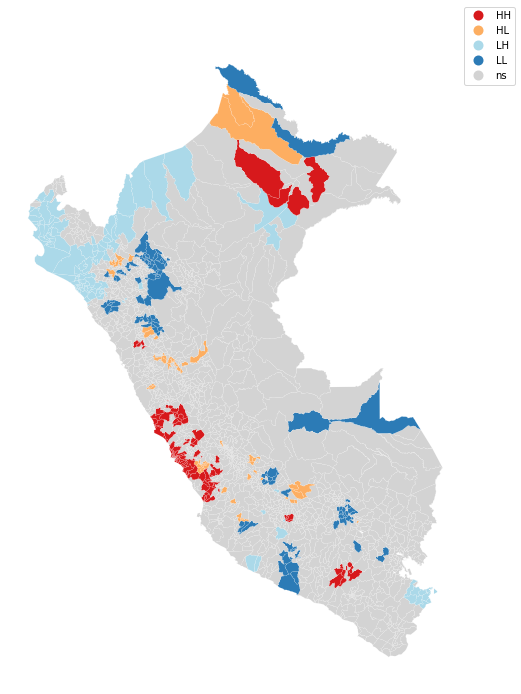

In [107]:
from esda.moran import Moran_Local_BV

lisab600covid = Moran_Local_BV(midis['b600prop'], 
                                  midis['covidShare'], 
                                  w)
from splot.esda import lisa_cluster

f, ax = plt.subplots(1, figsize=(12, 12))
fig = lisa_cluster(lisab600covid, 
                   midis,ax=ax,
                   legend_kwds={'loc': 'upper left', 
                                'bbox_to_anchor': (0.99, 1.05)})
plt.show()

In [109]:
# guardando cuadrante:
q_labels = ['1 HH', '2 LH', '3 LL', '4 HL']
labels = [q_labels[i-1] for i in lisab600covid.q]
midis=midis.assign(LisaBV_B600CovidQs=labels)

# guardando LISAs significativos
lisab600covid_sig = 1 * (lisab600covid.p_sim < 0.05) # de True/False a 1/0
labels = ['no-sig', 'significativo']  
labels = [labels[i] for i in lisab600covid_sig]
midis=midis.assign(LisaBV_B600CovidSig=labels)

hotSpot = 1 * (lisab600covid_sig * lisab600covid.q==1)
coldOutlier = 2 * (lisab600covid_sig * lisab600covid.q==2)
coldSpot = 3 * (lisab600covid_sig * lisab600covid.q==3)
hotOutlier = 4 * (lisab600covid_sig * lisab600covid.q==4)
spots = hotSpot + coldOutlier + coldSpot + hotOutlier
spot_labels = [ '0 no_sig', '1 hotSpot', '2 coldOutlier', '3 coldSpot', '4 hotOutlier']
labels = [spot_labels[i] for i in spots]
midis=midis.assign(LisaBV_B600CovidSpots=labels)

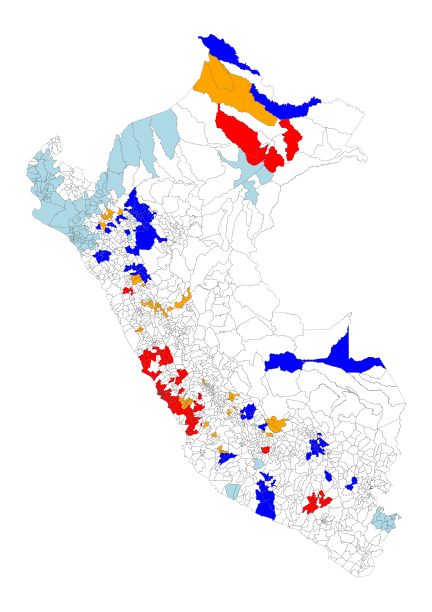

In [56]:
f, ax = plt.subplots(1, figsize=(11, 11))
midis.plot(column='LisaBV_B600CovidSpots',
                 categorical=True,
                 cmap=hmap,ax=ax,
                 linewidth=0.1,
                 edgecolor='black')#, legend=True)
ax.set_axis_off()

plt.show()

In [117]:
#midis.drop(columns=['BVLisa_lisaB600covidSig', 'BVLisa_SpotsB600Covid'],inplace=True)

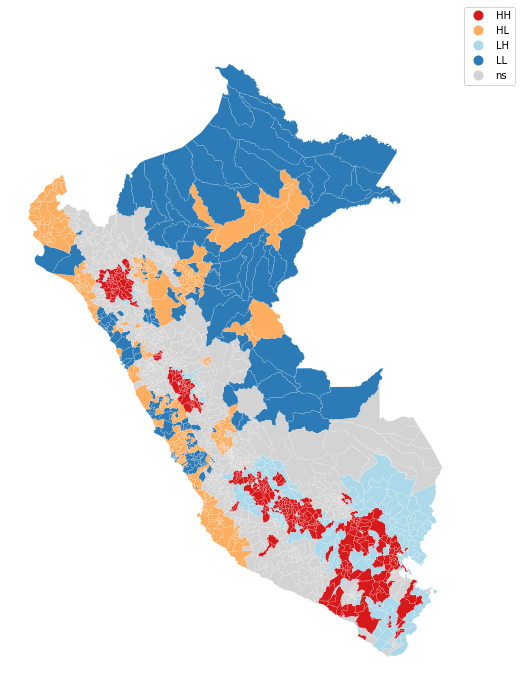

In [110]:

lisaYanaPre1 = Moran_Local_BV(midis['yanaProp'], 
                                  midis['Pres1_PLprop'], 
                                  w)

f, ax = plt.subplots(1, figsize=(12, 12))
fig = lisa_cluster(lisaYanaPre1, 
                   midis,ax=ax,
                   legend_kwds={'loc': 'upper left', 
                                'bbox_to_anchor': (0.99, 1.05)})
plt.show()

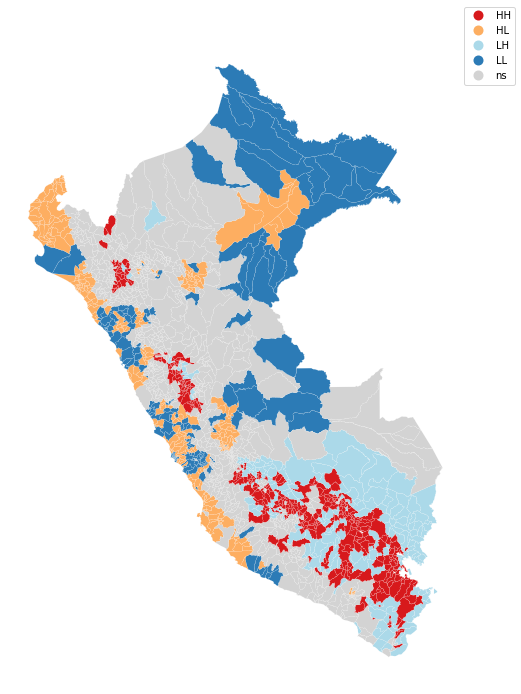

In [111]:

lisaYanaPre2 = Moran_Local_BV(midis['yanaProp'], 
                                  midis['Pres2_PLprop'], 
                                  w)

f, ax = plt.subplots(1, figsize=(12, 12))
fig = lisa_cluster(lisaYanaPre2, 
                   midis,ax=ax,
                   legend_kwds={'loc': 'upper left', 
                                'bbox_to_anchor': (0.99, 1.05)})
plt.show()

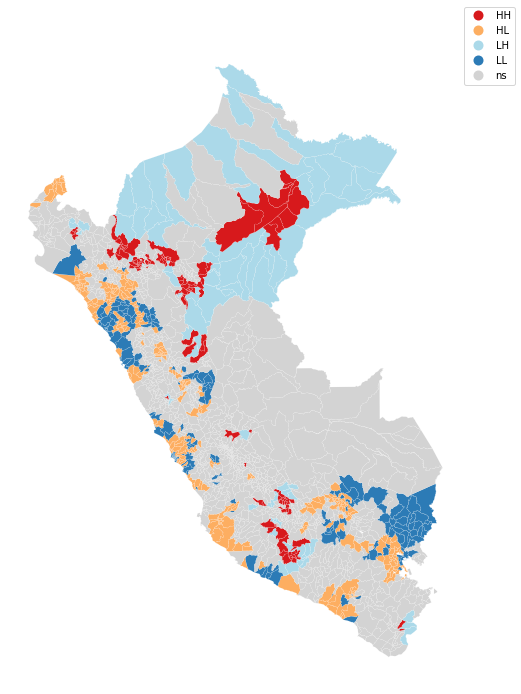

In [112]:
lisaYanaCong = Moran_Local_BV(midis['yanaProp'], 
                                  midis['Congre_PeruLibre_prop'], 
                                  w)

f, ax = plt.subplots(1, figsize=(12, 12))
fig = lisa_cluster(lisaYanaCong, 
                   midis,ax=ax,
                   legend_kwds={'loc': 'upper left', 
                                'bbox_to_anchor': (0.99, 1.05)})
plt.show()

In [114]:
# guardando cuadrante:
q_labels = ['1 HH', '2 LH', '3 LL', '4 HL']
labels = [q_labels[i-1] for i in lisaYanaCong.q]
midis=midis.assign(LisaBV_YanaCongQs=labels)

# guardando LISAs significativos
lisaYanaCong_sig = 1 * (lisaYanaCong.p_sim < 0.05) # de True/False a 1/0
labels = ['no-sig', 'significativo']  
labels = [labels[i] for i in lisaYanaCong_sig]
midis=midis.assign(LisaBV_YanaCongSig=labels)

hotSpot = 1 * (lisaYanaCong_sig * lisaYanaCong.q==1)
coldOutlier = 2 * (lisaYanaCong_sig * lisaYanaCong.q==2)
coldSpot = 3 * (lisaYanaCong_sig * lisaYanaCong.q==3)
hotOutlier = 4 * (lisaYanaCong_sig * lisaYanaCong.q==4)
spots = hotSpot + coldOutlier + coldSpot + hotOutlier
spot_labels = [ '0 no_sig', '1 hotSpot', '2 coldOutlier', '3 coldSpot', '4 hotOutlier']
labels = [spot_labels[i] for i in spots]
midis=midis.assign(LisaBV_YanaCongSpots=labels)


# guardando cuadrante:
q_labels = ['1 HH', '2 LH', '3 LL', '4 HL']
labels = [q_labels[i-1] for i in lisaYanaPre1.q]
midis=midis.assign(LisaBV_lisaYanaPre1Qs=labels)

# guardando LISAs significativos
lisaYanaPre1_sig = 1 * (lisaYanaPre1.p_sim < 0.05) # de True/False a 1/0
labels = ['no-sig', 'significativo']  
labels = [labels[i] for i in lisaYanaPre1_sig]
midis=midis.assign(LisaBV_lisaYanaPre1Sig=labels)

hotSpot = 1 * (lisaYanaPre1_sig * lisaYanaPre1.q==1)
coldOutlier = 2 * (lisaYanaPre1_sig * lisaYanaPre1.q==2)
coldSpot = 3 * (lisaYanaPre1_sig * lisaYanaPre1.q==3)
hotOutlier = 4 * (lisaYanaPre1_sig * lisaYanaPre1.q==4)
spots = hotSpot + coldOutlier + coldSpot + hotOutlier
spot_labels = [ '0 no_sig', '1 hotSpot', '2 coldOutlier', '3 coldSpot', '4 hotOutlier']
labels = [spot_labels[i] for i in spots]
midis=midis.assign(LisaBV_lisaYanaPre1Spots=labels)


# guardando cuadrante:
q_labels = ['1 HH', '2 LH', '3 LL', '4 HL']
labels = [q_labels[i-1] for i in lisaYanaPre2.q]
midis=midis.assign(LisaBV_lisaYanaPre2Qs=labels)

# guardando LISAs significativos
lisaYanaPre2_sig = 1 * (lisaYanaPre2.p_sim < 0.05) # de True/False a 1/0
labels = ['no-sig', 'significativo']  
labels = [labels[i] for i in lisaYanaPre2_sig]
midis=midis.assign(LisaBV_lisaYanaPre2Sig=labels)

hotSpot = 1 * (lisaYanaPre2_sig * lisaYanaPre2.q==1)
coldOutlier = 2 * (lisaYanaPre2_sig * lisaYanaPre2.q==2)
coldSpot = 3 * (lisaYanaPre2_sig * lisaYanaPre2.q==3)
hotOutlier = 4 * (lisaYanaPre2_sig * lisaYanaPre2.q==4)
spots = hotSpot + coldOutlier + coldSpot + hotOutlier
spot_labels = [ '0 no_sig', '1 hotSpot', '2 coldOutlier', '3 coldSpot', '4 hotOutlier']
labels = [spot_labels[i] for i in spots]
midis=midis.assign(LisaBV_lisaYanaPre2Spots=labels)

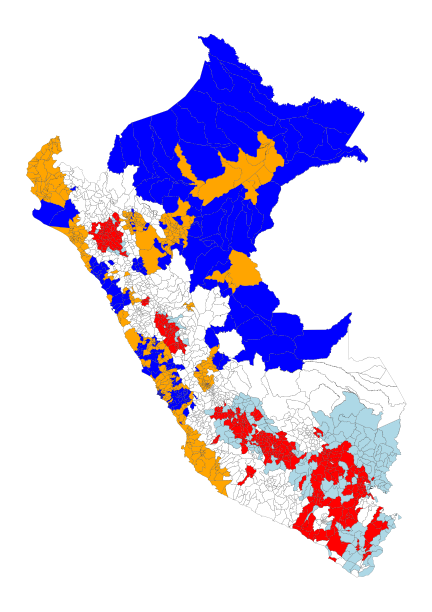

In [57]:
f, ax = plt.subplots(1, figsize=(11, 11))
midis.plot(column='LisaBV_lisaYanaPre1Spots',
                 categorical=True,
                 cmap=hmap,ax=ax,
                 linewidth=0.1,
                 edgecolor='black')#, legend=True)
ax.set_axis_off()
plt.show()

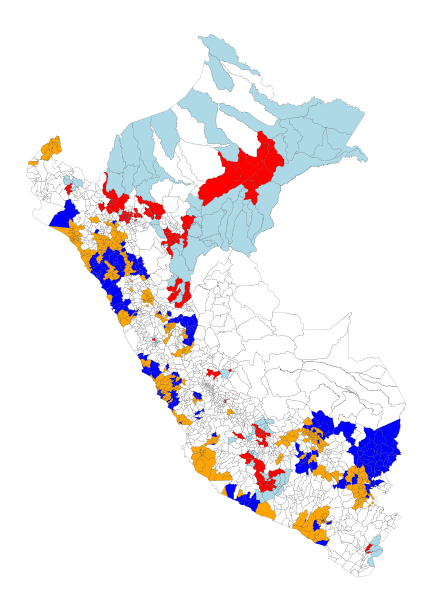

In [58]:
f, ax = plt.subplots(1, figsize=(11, 11))
midis.plot(column='LisaBV_YanaCongSpots',
                 categorical=True,
                 cmap=hmap,ax=ax,
                 linewidth=0.1,
                 edgecolor='black')#, legend=True)
ax.set_axis_off()
plt.show()

In [119]:
midis.to_file("midisceplanmap_repro.geojson", driver="GeoJSON")